# Hyperparameter tunning on *-1:00* data subset

In [1]:
# Import requiered Libraries
import os
import pandas as pd
from tqdm import tqdm

# Import custom classes for hyper-parameter tunning
import sys
PATH_TO_SRC = '/Users/masaver/Desktop/masaver/data_science_projects/sep24_bds_int_medical'
sys.path.append( PATH_TO_SRC )
from src.features.tuners.XGBHyperparameterTuner import XGBHyperparameterTuner
from src.features.tuners.LGBMHyperparameterTuner import LGBMHyperparameterTuner
from src.features.tuners.HistGradientBoostingHyperparameterTuner import HistGradientBoostingHyperparameterTuner
from src.features.tuners.LassoCVHyperparameterTuner import LassoCVHyperparameterTuner
from src.features.tuners.RidgeHyperparameterTuner import RidgeHyperparameterTuner
from src.features.tuners.KNeighborsHyperparameterTuner import KNeighborsHyperparameterTuner

# Import Dummy Regressor
from sklearn.dummy import DummyRegressor

# Import the preprocessign pipeline
from pipelines import *

# Disable warnings
import warnings
warnings.filterwarnings("ignore") 

# Import metrics for scoring
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Libraries for Plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read train and test data
data_file = os.path.join('..', '..' , '..', '..', 'data', 'raw', 'train.csv')
test_file = os.path.join('..', '..' , '..', '..', 'data', 'raw', 'test.csv')

df_train = pd.read_csv(data_file, index_col = 0 , parse_dates = True )
df_test = pd.read_csv(test_file, index_col = 0 , parse_dates = True )

Data Preprocessing.

Main steps:
* Re-Encoding of the **time** stamp into **day-phase**
* Drop the following collumns: **activity**, **carbs**, **steps** , **p_num** & **time**
* The NAs in the remaining columns are imputed with interpolation and median 
* Two negative values for insuling are set to 0
* The column **day-phase** is re-encoded with pd.get_dummies()
* Finally, all columns are transformed with a StandardScaler.

In [3]:
def subset_data( df , delta ):
    
    '''
    This function subsets the input data, based on a lag feature delta
    '''

    tmp_l = []
    metrics = ['bg','insulin','hr','cals']
    for metric in metrics:
        start_col= f'{metric}{delta}'
        end_col = f'{metric}-0:00'
        tmp_l.append( df.loc[ : , start_col:end_col ])

    # Append day-ühase features
    day_phase_feats = ['day_phase_evening','day_phase_late_evening','day_phase_morning','day_phase_night','day_phase_noon']
    tmp_l.append( df.loc[ : , day_phase_feats  ])

    return pd.concat( tmp_l , axis = 1 )


In [4]:
# Split the data into Features and Target variables, 
# and Standarize the features with the preprocessing pipelines
X = df_train.drop( 'bg+1:00' , axis = 1 )
y = df_train['bg+1:00']

data_pipe = pipeline
Xs = data_pipe.fit_transform( X )
Xs_test = data_pipe.transform( df_test )

# Subset features
Xs = subset_data( Xs , '-1:00' )
Xs_test = subset_data( Xs_test , '-1:00' )

# fix column names - Needed for LGBM
import re
Xs.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in Xs.columns]
Xs_test.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in Xs_test.columns]

# Display descriptive statistics
display( Xs.describe() )
display( Xs_test.describe() )

,bg_1_00,bg_0_55,bg_0_50,bg_0_45,bg_0_40,bg_0_35,bg_0_30,bg_0_25,bg_0_20,bg_0_15,...,cals_0_20,cals_0_15,cals_0_10,cals_0_05,cals_0_00,day_phase_evening,day_phase_late_evening,day_phase_morning,day_phase_night,day_phase_noon
count,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,...,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05
mean,3.853269e-18,-2.889951e-16,-6.460647e-16,-3.545007e-16,-1.952323e-16,-5.561551e-16,-7.719381e-16,4.277128e-16,-8.464347e-16,-1.631217e-16,...,1.592684e-16,1.644061e-16,4.623922e-17,-1.541307e-17,2.260584e-16,-3.901434e-17,-1.461031e-17,-1.031552e-17,-7.385432e-18,-1.590276e-16
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-2.029007e+00,-2.031407e+00,-2.030949e+00,-2.028572e+00,-2.031076e+00,-2.030721e+00,-2.028285e+00,-2.030903e+00,-2.030622e+00,-2.028078e+00,...,-1.132252e+00,-1.131288e+00,-1.131634e+00,-1.132097e+00,-1.134014e+00,-4.444915e-01,-2.978734e-01,-4.491221e-01,-5.752456e-01,-4.505926e-01
25%,-7.272977e-01,-7.281400e-01,-7.279555e-01,-7.271056e-01,-7.279814e-01,-7.278228e-01,-7.269317e-01,-7.278248e-01,-7.276766e-01,-7.267160e-01,...,-3.878293e-01,-3.873843e-01,-3.875796e-01,-3.875481e-01,-3.873682e-01,-4.444915e-01,-2.978734e-01,-4.491221e-01,-5.752456e-01,-4.505926e-01
50%,-1.932629e-01,-1.934662e-01,-1.933942e-01,-1.931705e-01,-1.933784e-01,-1.933003e-01,-1.930434e-01,-1.932287e-01,-1.931349e-01,-1.928241e-01,...,-3.103131e-01,-3.099221e-01,-3.101018e-01,-3.100189e-01,-3.096205e-01,-4.444915e-01,-2.978734e-01,-4.491221e-01,-5.752456e-01,-4.505926e-01
75%,5.410350e-01,5.417102e-01,5.416276e-01,5.409902e-01,5.417007e-01,5.416680e-01,5.410531e-01,5.418411e-01,5.418600e-01,5.412772e-01,...,-1.031577e-01,-1.042468e-01,-1.043850e-01,-1.028285e-01,-1.045274e-01,-4.444915e-01,-2.978734e-01,-4.491221e-01,-5.752456e-01,-4.505926e-01
max,6.515549e+00,6.523373e+00,6.522032e+00,6.514389e+00,6.522572e+00,6.521638e+00,6.513929e+00,6.522636e+00,6.522045e+00,6.514193e+00,...,1.438034e+01,1.437049e+01,1.437327e+01,1.438312e+01,1.442491e+01,2.249762e+00,3.357131e+00,2.226566e+00,1.738388e+00,2.219300e+00


,bg_1_00,bg_0_55,bg_0_50,bg_0_45,bg_0_40,bg_0_35,bg_0_30,bg_0_25,bg_0_20,bg_0_15,...,cals_0_20,cals_0_15,cals_0_10,cals_0_05,cals_0_00,day_phase_evening,day_phase_late_evening,day_phase_morning,day_phase_night,day_phase_noon
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,...,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000
mean,0.139332,0.137628,0.137202,0.134769,0.133272,0.132476,0.132239,0.132332,0.130075,0.128647,...,-0.166944,-0.160694,-0.159051,-0.163727,-0.169704,0.020570,-0.006998,-0.021041,0.015226,0.016126
std,1.085534,1.083052,1.083305,1.083411,1.082144,1.080208,1.082061,1.081877,1.084214,1.085989,...,0.891142,0.891972,0.910754,0.911728,0.933371,1.018330,0.989349,0.981031,1.008840,1.014172
min,-2.029007,-2.031407,-2.030949,-2.028572,-2.031076,-2.030721,-2.028285,-2.030903,-2.030622,-2.028078,...,-1.133589,-1.132624,-1.132969,-1.133433,-1.135355,-0.444492,-0.297873,-0.449122,-0.575246,-0.450593
25%,-0.627166,-0.627889,-0.627725,-0.626993,-0.627743,-0.627600,-0.626828,-0.627588,-0.627450,-0.626611,...,-0.534843,-0.534295,-0.534520,-0.534586,-0.537837,-0.444492,-0.297873,-0.449122,-0.575246,-0.450593
50%,-0.093131,-0.093215,-0.093164,-0.093058,-0.093140,-0.093077,-0.092939,-0.092992,-0.092908,-0.092719,...,-0.403867,-0.382376,-0.397598,-0.413614,-0.423561,-0.444492,-0.297873,-0.449122,-0.575246,-0.450593
75%,0.695126,0.708796,0.675268,0.674474,0.675351,0.675299,0.674525,0.675490,0.675495,0.674750,...,-0.234133,-0.226784,-0.233960,-0.215112,-0.233213,-0.444492,-0.297873,-0.449122,1.738388,-0.450593
max,6.515549,6.523373,6.522032,6.514389,6.422334,6.321192,6.213617,5.876666,5.642279,5.679987,...,7.689893,7.684706,7.214594,9.294255,9.190347,2.249762,3.357131,2.226566,1.738388,2.219300


Model tunning

In [ ]:
# # Instantiate and fit the Tunners
# dummy_reg = DummyRegressor()
# xgb_tuner = XGBHyperparameterTuner( search_space = 'default' )
# lgbm_tuner = LGBMHyperparameterTuner( search_space = 'default' )
# hist_tuner = HistGradientBoostingHyperparameterTuner( search_space = 'default' )
# lasso_tuner = LassoCVHyperparameterTuner( search_space = 'default' )
# ridge_tuner = RidgeHyperparameterTuner( search_space = 'default' )
# knn_tuner  = KNeighborsHyperparameterTuner( search_space = 'default' )

# print('Fitting dummy regressor ... ')
# dummy_reg.fit(X=Xs, y=y)

# print('Fitting XGB Tuner ... ')
# xgb_tuner.fit(X=Xs, y=y)

# print('Fitting LGBM regressor ... ')
# lgbm_tuner.fit(X=Xs, y=y)

# print('Fitting HistGradientBoosting regressor ... ')
# hist_tuner.fit(X=Xs, y=y)

# print('Fitting LassoCV regressor ... ')
# lasso_tuner.fit(X=Xs, y=y)

# print('Fitting RidgeCV regressor ... ')
# ridge_tuner.fit(X=Xs, y=y)

# print('Fitting KNN regressor ... ')
# knn_tuner.fit(X=Xs, y=y)

In [5]:
# Save or Read results from hyper-parameter tunning
def save_pickle( obj , file_name ):
    
    import pickle
    # Save to pickle file
    file_path = f'./models/bayes_search_res/{file_name}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f)

    f.close()

def read_pickle( file_name ):
    import pickle

    # Specify the path to your pickle file
    file_path = f'./models/bayes_search_res/{file_name}.pkl'
    
    # Open the pickle file in binary read mode and load the object
    with open(file_path, 'rb') as f:
        obj = pickle.load( f )

    f.close()

    return obj

# # # Save results
# save_pickle( xgb_tuner , 'xgb_tuner_res' )
# save_pickle( lgbm_tuner , 'lgbm_tuner_res' )
# save_pickle( hist_tuner , 'hist_tuner_res' )
# save_pickle( lasso_tuner , 'lasso_tuner_res' )
# save_pickle( ridge_tuner , 'ridge_tuner_res' )
# save_pickle( knn_tuner , 'knn_tuner_res' )
# save_pickle( dummy_reg , 'dummy_reg_res' )

# # Read Results
xgb_tuner = read_pickle( 'xgb_tuner_res' )
lgbm_tuner= read_pickle( 'lgbm_tuner_res' )
hist_tuner = read_pickle( 'hist_tuner_res' )
lasso_tuner = read_pickle( 'lasso_tuner_res' )
ridge_tuner = read_pickle( 'ridge_tuner_res' )
knn_tuner = read_pickle( 'knn_tuner_res' )
dummy_reg = read_pickle( 'dummy_reg_res' )

In [6]:
# Extract Best Models
xgb_best_model = xgb_tuner.get_best_model()
lgbm_best_model = lgbm_tuner.get_best_model()
hist_best_model = hist_tuner.get_best_model()
lasso_best_model = lasso_tuner.get_best_model()
ridge_best_model = ridge_tuner.get_best_model()
knn_best_model = knn_tuner.get_best_model()

# Print the CV RMSE for the best models
xgb_rmse = root_mean_squared_error( y_true = y , y_pred = xgb_best_model.predict( X = Xs ) )
lgmb_rmse = root_mean_squared_error( y_true = y , y_pred = lgbm_best_model.predict( X = Xs ) )
hist_rmse = root_mean_squared_error( y_true = y , y_pred = hist_best_model.predict( X = Xs ) )
lasso_rmse = root_mean_squared_error( y_true = y , y_pred = lasso_best_model.predict( X = Xs ) )
ridge_rmse = root_mean_squared_error( y_true = y , y_pred = ridge_best_model.predict( X = Xs ) )
knn_rmse = root_mean_squared_error( y_true = y , y_pred = knn_best_model.predict( X = Xs ) )
dummy_rmse = root_mean_squared_error( y_true = y , y_pred = dummy_reg.predict( X = Xs ) )

rmse_df = pd.DataFrame({
    'model':['xgb','lgbm','hist','lasso','ridge','knn','dummy'],
    'rmse':[xgb_rmse,lgmb_rmse,hist_rmse,lasso_rmse,ridge_rmse,knn_rmse,dummy_rmse]
})

rmse_df.sort_values( 'rmse' , inplace = True )

display( rmse_df )

,model,rmse
5,knn,0.025463
1,lgbm,0.865829
2,hist,1.521435
0,xgb,1.557928
4,ridge,2.063558
3,lasso,2.063651
6,dummy,2.996390


XGBoost model - Real vs. Predicted correlation & Residuals distribution

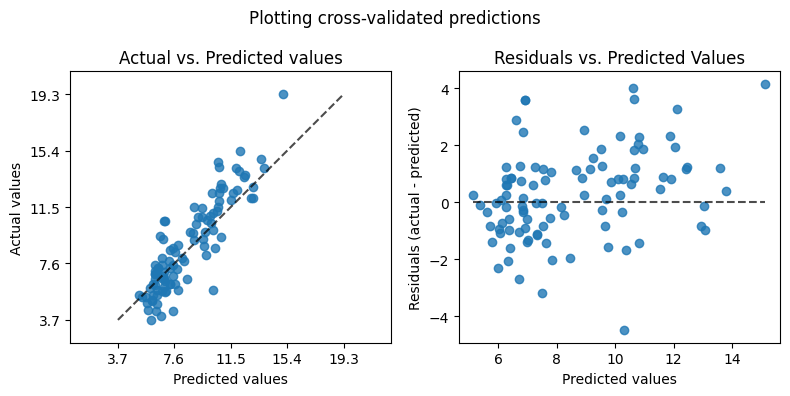

In [7]:
xgb_tuner.show_chart()

LGBM model - Real vs. Predicted correlation & Residuals distribution

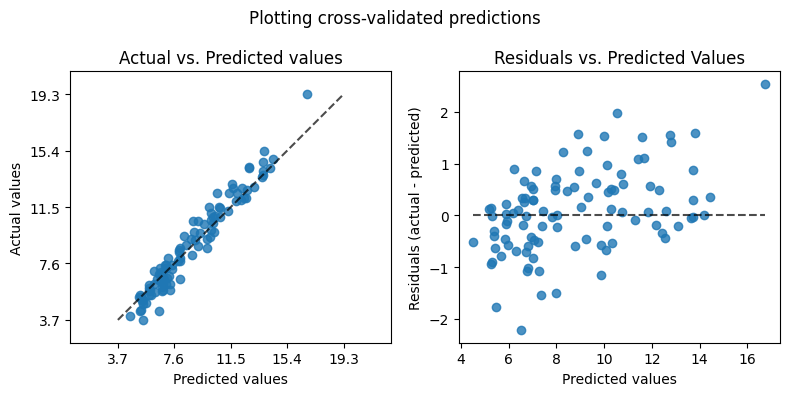

In [8]:
lgbm_tuner.show_chart()

HistGradientBoosting model - Real vs. Predicted correlation & Residuals distribution

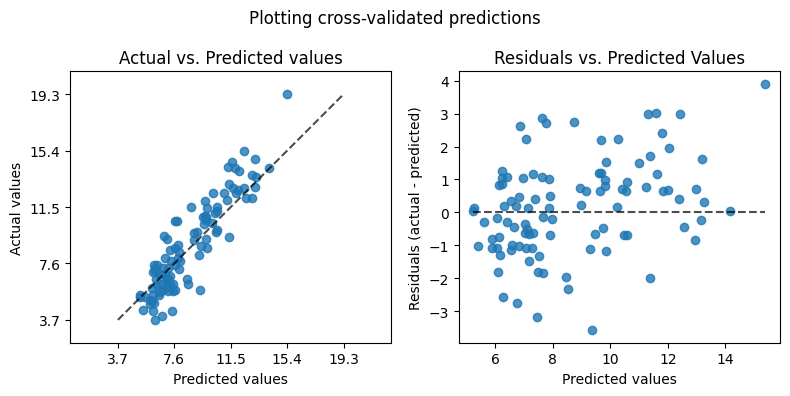

In [9]:
hist_tuner.show_chart()

Lasso model - Real vs. Predicted correlation & Residuals distribution

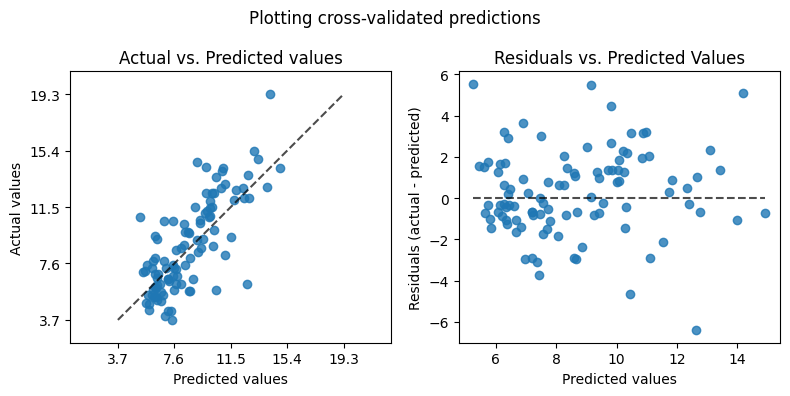

In [10]:
lasso_tuner.show_chart()

Ridge model - Real vs. Predicted correlation & Residuals distribution

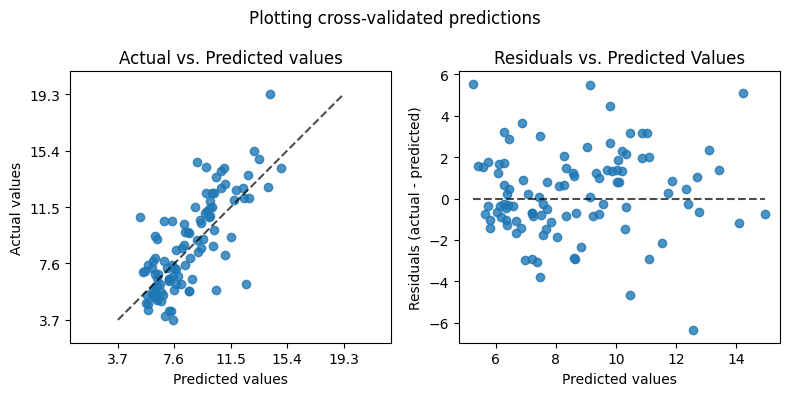

In [11]:
ridge_tuner.show_chart()

KNN model - Real vs. Predicted correlation & Residuals distribution

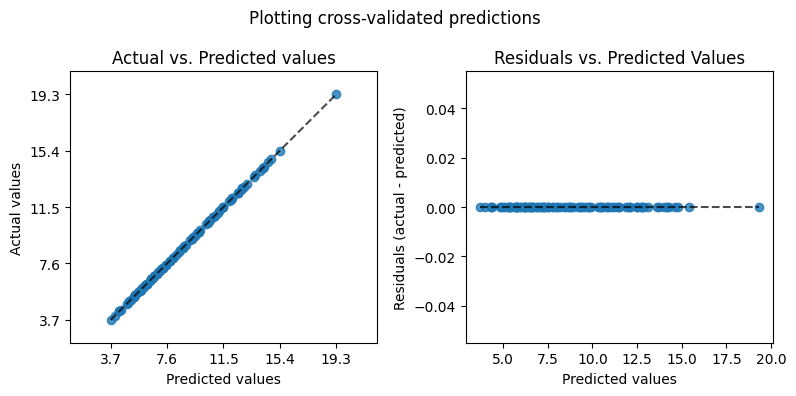

In [12]:
knn_tuner.show_chart()

Calculate Cross-Validated RMSE scores for Train/Test splits using the top 100 features ( based on SHAP importance )

In [13]:
def train_test_cv( model , name_tag ):

    from src.features.helpers.ShapWrapper import ShapWrapper

    print(f'Calculating scores for {name_tag}')

    # Perform cross-validation, specifying both train and test scores
    cv_results = cross_validate(
        model, Xs, y, cv=5,
        scoring = rmse_scorer , 
        return_train_score=True
    )

    # Extract train and test scores
    train_scores = cv_results['train_score']
    test_scores = cv_results['test_score']

    #Create a results df
    res = pd.DataFrame([{
        'model':name_tag,
        'train_rmse':-1*train_scores.mean(),
        'test_rmse':-1*test_scores.mean()
    }])
        

    return res


In [14]:
xgb_rmse_vals = train_test_cv( knn_best_model , 'XGBoost' )
lgbm_rmse_vals = train_test_cv( lgbm_best_model , 'LGBM' )
hist_rmse_vals = train_test_cv( hist_best_model , 'HistGradient' )
lasso_rmse_vals = train_test_cv( lasso_best_model , 'Lasso' )
ridge_rmse_vals = train_test_cv( ridge_best_model , 'Ridge' )
knn_rmse_vals = train_test_cv( knn_best_model , 'KNN' )
dummy_rmse_vals = train_test_cv( dummy_reg , 'Dummy' )

res = pd.concat([
    xgb_rmse_vals,lgbm_rmse_vals,hist_rmse_vals,
    lasso_rmse_vals,ridge_rmse_vals,knn_rmse_vals,
    dummy_rmse_vals
])

res.sort_values( 'test_rmse' , inplace=True )
display( res )

Calculating scores for XGBoost
Calculating scores for LGBM
Calculating scores for HistGradient
Calculating scores for Lasso
Calculating scores for Ridge
Calculating scores for KNN
Calculating scores for Dummy


,model,train_rmse,test_rmse
0,Lasso,2.061017,2.075593
0,Ridge,2.060917,2.075859
0,HistGradient,1.448100,2.118899
0,LGBM,0.765054,2.148105
0,XGBoost,0.025245,2.565413
0,KNN,0.025245,2.565413
0,Dummy,2.993084,3.012515


Investigate the correlation between the predictions of the individual models

In [25]:
preds_df = pd.DataFrame({
    'lasso':lasso_best_model.predict(Xs),
    'ridge':ridge_best_model.predict(Xs),
    'hist':hist_best_model.predict(Xs),
    'lgbm':lgbm_best_model.predict(Xs),
    'xgb':xgb_best_model.predict(Xs),
    'knn':knn_best_model.predict(Xs)
})

preds_df

,lasso,ridge,hist,lgbm,xgb,knn
0,12.306678,12.312083,12.110231,12.186870,12.679951,13.4
1,12.082017,12.087946,12.467745,12.041717,12.486846,12.8
2,11.857625,11.858771,12.685652,13.358781,12.913714,15.5
3,12.006891,12.010565,13.557188,14.731237,13.956044,14.8
4,11.541601,11.538474,12.555115,13.439661,12.753971,12.7
...,...,...,...,...,...,...
177019,9.848038,9.818149,10.292373,10.744910,10.633542,11.1
177020,10.678201,10.726784,10.765858,11.010088,11.536282,10.9
177021,10.837952,10.821754,10.830504,10.839572,10.884369,10.7
177022,10.900486,10.913382,11.256298,11.105478,11.130271,10.5


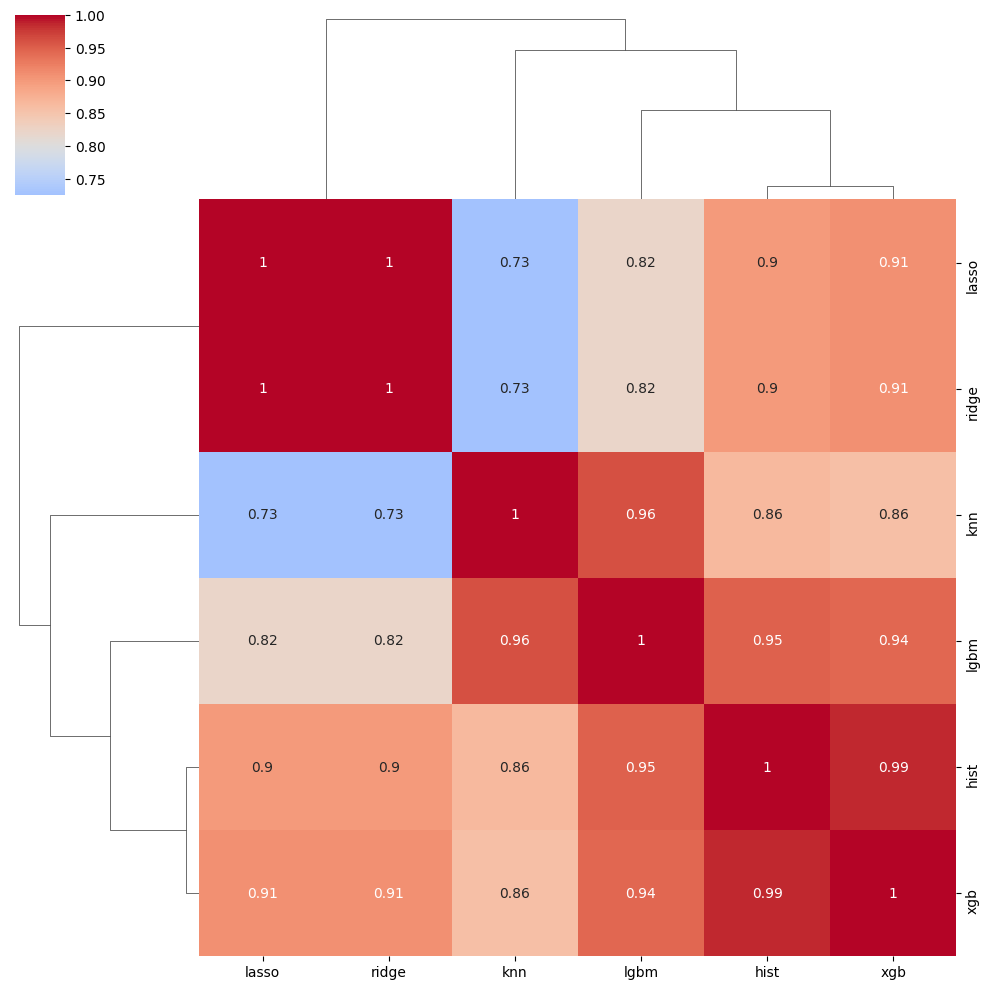

In [28]:
sns.clustermap( preds_df.corr() , center = 0.8 , cmap = 'coolwarm' , annot = True)

Using the model predictions,test the Ridge Tuner

Combine the tuned Regressors into an ensemble model ( VotingRegressor )

In [15]:
from sklearn.ensemble import VotingRegressor

# Create a VotingRegressor
voting_regressor = VotingRegressor(estimators=[
    ('lasso', lasso_best_model),
    ('ridge', ridge_best_model),
    ('hist', hist_best_model),
    ('xgb',xgb_best_model),
    ('lgbm',lgbm_best_model),
    ('knn',knn_best_model)
])

# Fit the ensemble regressor
voting_regressor.fit(Xs, y)

# Calculate CVed RMSE scores for the VotingRegressor
voting_rmse_vals = train_test_cv( voting_regressor , 'Voting Regressor_-1:00' )
voting_rmse_vals

Calculating scores for Voting Regressor_-1:00


,model,train_rmse,test_rmse
0,Voting Regressor_-1:00,1.24443,2.041542


Prepare tables for kaggle submission

In [16]:
def prep_submission_table( model , tag ):
    
    print(f'Predicitng with the { tag } model ... \n')
    pred_df = pd.DataFrame({
    'id' : Xs_test.index , 
    'bg+1:00' :  model.predict( Xs_test )
    })
    
    output_name = f'./submissions/{tag}_res.csv'
    pred_df.to_csv( output_name , index=False )
    # display( pred_df )

prep_submission_table( voting_regressor , 'Voting Regressor_-1:00' )


Predicitng with the Voting Regressor_-1:00 model ... 



In [30]:
%%time
stacked_ridge_tuner = RidgeHyperparameterTuner( search_space = 'default' )
stacked_ridge_tuner.fit( preds_df , y )
stacked_ridge_tuner.get_params()

CPU times: user 56.5 s, sys: 7.87 s, total: 1min 4s
Wall time: 15.6 s


OrderedDict([('alpha', 0.07034124143129218)])

Combine the tuned Regressors into an ensemble model ( Stacking Regressor )

In [31]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor

estimators=[
    ('lasso', lasso_best_model),
    ('ridge', ridge_best_model),
    ('hist', hist_best_model),
    ('xgb',xgb_best_model),
    ('lgbm',lgbm_best_model),
    ('knn',knn_best_model)
]

stacking_regressor  = StackingRegressor( 
    estimators = estimators , 
    final_estimator = Ridge( **stacked_ridge_tuner.get_params() ) 
    )

stacking_regressor.fit(Xs, y)

# Calculate CVed RMSE scores for the StackingRegressor
stacking_rmse_vals = train_test_cv( stacking_regressor , 'Stacking Regressor_-1:00_RydgeTuned' )
stacking_rmse_vals

Calculating scores for Stacking Regressor_-1:00_RydgeTuned


,model,train_rmse,test_rmse
0,Stacking Regressor_-1:00_RydgeTuned,1.56679,2.019727


In [32]:
# save the final estimator + tuned final estimator
save_pickle( stacking_regressor  , 'Stacking Regressor_-1:00_RydgeTuned' )

In [33]:
prep_submission_table( stacking_regressor , 'Stacking Regressor_-1:00_RydgeTuned' )

Predicitng with the Stacking Regressor_-1:00_RydgeTuned model ... 



Summary
* Based on RMSE, correlation and residual plots, we see that the three tested models peroform reasonably well
* The best performance after hyper-parameter tunning can be achieved with the Top 10 most important features ( based on SHAP values )
* For all the three Tree-based models tested, **bg-0:00** is prominently the most important feature .